In [1]:
!pip install opencv-python matplotlib numpy paddlepaddle "paddleocr>=2.7" seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: C:\work\Learning OCR\.venv\Scripts\python.exe -m pip install --upgrade pip


In [2]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd
import re
import random
from datetime import datetime
import json
import csv
import glob
from paddleocr import PaddleOCR
from collections import defaultdict
from tqdm import tqdm

c:\work\Learning-OCR (Fixed)\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
BASE = "train"
IMG_DIR = os.path.join(BASE, "img")
BOX_DIR = os.path.join(BASE, "box")

In [4]:
if os.path.exists(IMG_DIR):
    print("Files in IMG_DIR:", os.listdir(IMG_DIR)[:5])
else:
    print(f"Error: Folder {IMG_DIR} tidak ditemukan.")

Files in IMG_DIR: ['X00016469612.jpg', 'X00016469619.jpg', 'X00016469620.jpg', 'X00016469622.jpg', 'X00016469623.jpg']


In [5]:
sample_name = os.listdir(IMG_DIR)[0].split(".")[0]
img_path = os.path.join(IMG_DIR, f"{sample_name}.jpg")
box_path = os.path.join(BOX_DIR, f"{sample_name}.txt")

print("img_path:", img_path)
print("box_path:", box_path)

img_path: train\img\X00016469612.jpg
box_path: train\box\X00016469612.txt


In [6]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [7]:
boxes = []
if os.path.exists(box_path):
    with open(box_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split(',')
            coords = list(map(int, parts[:8]))
            text = ",".join(parts[8:])
            pts = np.array(coords).reshape(4, 2)
            boxes.append((pts, text))

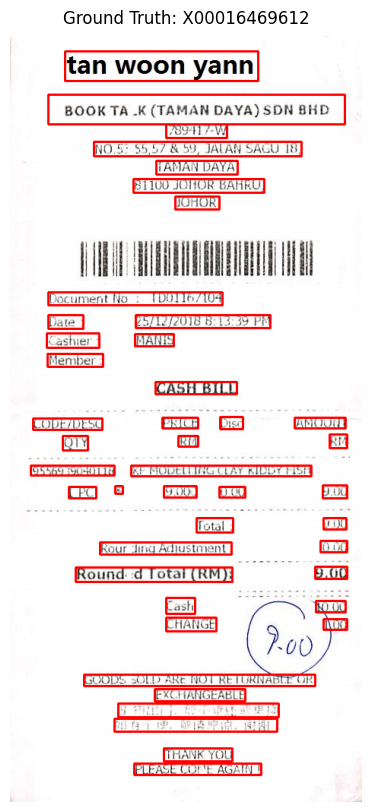

In [8]:
img_copy = img.copy()
for pts, text in boxes:
    cv2.polylines(img_copy, [pts], isClosed=True, color=(255, 0, 0), thickness=2)

# Tampilkan
plt.figure(figsize=(10,10))
plt.imshow(img_copy)
plt.axis("off")
plt.title(f"Ground Truth: {sample_name}")
plt.show()

In [9]:
image_files = os.listdir(IMG_DIR)
num_samples = 6
# Random sample agar tidak bosan melihat gambar yang sama
selected_files = random.sample(image_files, num_samples)

In [10]:
def load_annotation(box_path):
    boxes = []
    if os.path.exists(box_path):
        with open(box_path, "r", encoding="utf-8") as f:
            for line in f:
                parts = line.strip().split(',')
                try:
                    coords = list(map(int, parts[:8]))
                    pts = np.array(coords).reshape(4, 2)
                    text = ",".join(parts[8:])
                    boxes.append((pts, text))
                except:
                    continue # Skip line error
    return boxes

In [11]:
cols = 2
rows = (num_samples + cols - 1) // cols 

plt.figure(figsize=(20, 10 * rows))

<Figure size 2000x3000 with 0 Axes>

<Figure size 2000x3000 with 0 Axes>

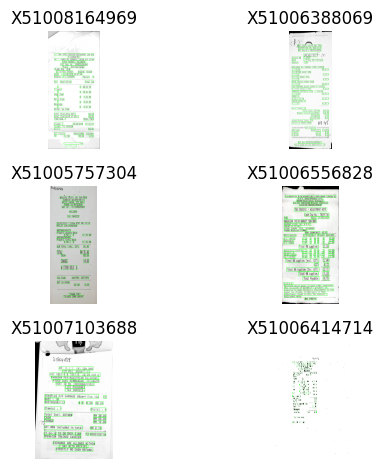

In [12]:
for idx, img_file in enumerate(selected_files):
    sample_name = img_file.split(".")[0]
    i_path = os.path.join(IMG_DIR, img_file)
    b_path = os.path.join(BOX_DIR, f"{sample_name}.txt")

    img_data = cv2.imread(i_path)
    if img_data is None: continue
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)

    ann_boxes = load_annotation(b_path)
    
    # Draw boxes
    for pts, text in ann_boxes:
        cv2.polylines(img_data, [pts], True, (0, 255, 0), 2) # Hijau untuk GT

    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img_data)
    plt.title(sample_name, fontsize=12)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [13]:
def normalize_text(s):
    s = str(s).replace('\ufffd', '').strip()
    return re.sub(r'\s+', ' ', s)

In [14]:
def poly_centroid(poly):
    cx = int(np.mean(poly[:,0])) # Rata-rata sumbu X
    cy = int(np.mean(poly[:,1])) # Rata-rata sumbu Y
    return cx, cy

In [15]:
def extract_money(s):
    """Mencari angka uang dalam string (misal: 'RM 12.50' -> 12.50)."""
    s_clean = s.replace(',', '') # Hapus pemisah ribuan (1,000 -> 1000)
    # Cari pola angka desimal (prioritas)
    m = re.search(r"\d+\.\d{2}", s_clean) 
    if not m:
        # Jika tidak ada desimal, cari angka biasa
        m = re.search(r"\d+", s_clean)
    return float(m.group()) if m else None

In [16]:
def group_rows(items, y_tol=15):
    """Mengelompokkan kata-kata menjadi baris berdasarkan posisi vertikal (cy)."""
    # 1. Urutkan semua kata berdasarkan posisi Y (dari atas ke bawah)
    items_sorted = sorted(items, key=lambda x: x['cy'])
    
    rows = []
    for it in items_sorted:
        placed = False
        # 2. Cek apakah kata ini sejajar dengan baris yang sudah ada?
        for row in rows:
            # Jika selisih Y <= toleransi (misal 15 pixel), anggap satu baris
            if abs(it['cy'] - row['cy_mean']) <= y_tol:
                row['items'].append(it)
                # Update rata-rata posisi Y baris tersebut
                row['cy_mean'] = sum(i['cy'] for i in row['items']) / len(row['items'])
                placed = True
                break
        
        # 3. Jika tidak sejajar dengan baris manapun, buat baris baru
        if not placed:
            rows.append({'items':[it], 'cy_mean': it['cy']})
    
    # 4. Dalam setiap baris, urutkan kata dari Kiri ke Kanan (xmin)
    for row in rows:
        row['items'] = sorted(row['items'], key=lambda x: x['xmin'])
    
    return rows

In [17]:
def row_to_string(row):
    """Menggabungkan list kata dalam satu baris menjadi satu string panjang."""
    full_text = " ".join([it['text'] for it in row['items']])
    return {
        'text': full_text,
        'cy': row.get('cy_mean'),
        'items': row['items'] # Simpan metadata asli untuk referensi
    }

In [18]:
def classify_row(text: str) -> str:
    t = text.lower()

    summary_kw = [
        "total", "subtotal", "cash", "change",
        "balance", "rounding", "gst", "tax", "visa"
    ]

    footer_kw = [
        "thank you", "visit again", "come again"
    ]

    # SUMMARY
    if any(k in t for k in summary_kw):
        return "summary"

    # FOOTER
    if any(k in t for k in footer_kw):
        return "footer"

    # ITEM → ada harga
    if re.search(r"\d+\.\d{2}", t):
        return "item"

    # HEADER default
    return "header"

In [19]:
def process_ocr(img_path, ocr, y_tol=12):
    """
    Jalankan OCR + parsing dasar → row-level text
    Return: rows_merged (list of dict)
    """
    
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image not found: {img_path}")

    result = ocr.predict(img_path)
    if result is None or len(result) == 0:
        return []

    raw_items = []

    res_obj = result[0]

    # ---- CASE 1: PaddleX / dict style ----
    if isinstance(res_obj, dict):
        keys_poly = ["dt_polys", "rec_polys", "polys", "boxes"]
        keys_text = ["rec_texts", "texts", "rec_text", "text"]

        key_poly = next((k for k in keys_poly if k in res_obj), None)
        key_text = next((k for k in keys_text if k in res_obj), None)

        if key_poly and key_text:
            polys = res_obj[key_poly]
            texts = res_obj[key_text]

            for poly_raw, text in zip(polys, texts):
                poly = np.array(poly_raw, dtype=np.float32).reshape(-1, 2)
                cx, cy = poly_centroid(poly)

                raw_items.append({
                    "text": normalize_text(text),
                    "poly": poly,
                    "cx": cx,
                    "cy": cy,
                    "xmin": int(np.min(poly[:, 0])),
                    "xmax": int(np.max(poly[:, 0]))
                })

    # ---- CASE 2: Legacy list style ----
    elif isinstance(res_obj, list):
        for line in res_obj:
            poly = np.array(line[0], dtype=np.float32).reshape(-1, 2)
            content = line[1]
            text = content[0] if isinstance(content, (list, tuple)) else str(content)

            cx, cy = poly_centroid(poly)

            raw_items.append({
                "text": normalize_text(text),
                "poly": poly,
                "cx": cx,
                "cy": cy,
                "xmin": int(np.min(poly[:, 0])),
                "xmax": int(np.max(poly[:, 0]))
            })

    if not raw_items:
        return []

    # ---- GROUP → ROW ----
    rows = group_rows(raw_items, y_tol=y_tol)
    rows_merged = []

    for idx, r in enumerate(rows):
        row = row_to_string(r)
        row["type"] = classify_row(row["text"])
        row["row_idx"] = idx
        row["row_ratio"] = round(idx / max(len(rows) - 1, 1), 3)
        rows_merged.append(row)

    return rows_merged

In [20]:
ocr = PaddleOCR(use_textline_orientation=True, lang='en')

c:\work\Learning-OCR (Fixed)\.venv\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\user\.paddlex\official_models\PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\user\.paddlex\official_models\UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\user\.paddlex\official_models\PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)
Mode

In [21]:
rows_for_labeling = []

for img_name in image_files:
    img_path = os.path.join(IMG_DIR, img_name)
    rows = process_ocr(img_path, ocr)

    for r in rows:
        rows_for_labeling.append({
            "image": img_name,
            "row_idx": r["row_idx"],
            "row_ratio": r["row_ratio"],
            "type": r["type"],
            "text": r["text"]
        })

Resized image size (6981x4945) exceeds max_side_limit of 4000. Resizing to fit within limit.
Resized image size (7016x4961) exceeds max_side_limit of 4000. Resizing to fit within limit.
Resized image size (7016x4961) exceeds max_side_limit of 4000. Resizing to fit within limit.
Resized image size (7016x4961) exceeds max_side_limit of 4000. Resizing to fit within limit.
Resized image size (7016x4961) exceeds max_side_limit of 4000. Resizing to fit within limit.
Resized image size (7016x4961) exceeds max_side_limit of 4000. Resizing to fit within limit.
Resized image size (7016x4961) exceeds max_side_limit of 4000. Resizing to fit within limit.
Resized image size (7016x4961) exceeds max_side_limit of 4000. Resizing to fit within limit.
Resized image size (7016x4961) exceeds max_side_limit of 4000. Resizing to fit within limit.
Resized image size (7016x4961) exceeds max_side_limit of 4000. Resizing to fit within limit.
Resized image size (6888x4912) exceeds max_side_limit of 4000. Resizin

In [22]:
df = pd.DataFrame(rows_for_labeling)
df.to_csv("ocr_rows_for_labeling.csv", index=False, encoding="utf-8")